# Energy Efficient GPU Computing - Tutorial

## Hands-on: Mixed Precision

This notebook shows an example of how we can use mixed precision to improve the performance and energy efficiency of our GPU code. We'll again use Kernel Tuner to benchmark different code variants and Kernel Float for simplified mixed-precision CUDA programming.

### Dependencies
First, we need to install `kernel_tuner`, `cuda-python`, and `pynvml` from `pip`. Afer this, we can import the necessary packages into python.

In [1]:
%%capture
!pip install kernel_tuner==1.0.0b5 cuda-python==11.8 pynvml seaborn==0.13

import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn
import scipy.signal.windows

Next, we need to download Kernel Float. Since `kernel_float` is a header-only library, the simplest method of using it is to download the `single_include` version of the library, which downloads just a single C++ header file.

In [2]:
%%capture
!wget -O kernel_float.h https://raw.githubusercontent.com/KernelTuner/kernel_float/v0.2/single_include/kernel_float.h

The next cell will write the CUDA kernel that we will be tuning to `convolution.cu`. The kernel is a simple 1D convolution kernel.

It has the following tunable parameters:
* Data types:
 * `INPUT_TYPE`: Type of input data.
 * `OUTPUT_TYPE`: Type of output data.
 * `FILTER_TYPE`: Type of filter.
 * `ACCUM_TYPE`: Type used inside kernel for the accumulation.
* Parameters:
 * `block_size_x`: Threads per block.
 * `VECTOR_SIZE`: Number of elements assigned to each thread.
 * `PREFETCH_INPUT`: Whether to use shared memory to prefetch inputs.
 * `loop_unroll_factor_filter`: How much to unroll the inner loop.

While you can take a look at the code, there is no need to modify it or fully understand the details for this hands-on session.


In [3]:
%%writefile convolution.cu

#include "kernel_float.h"

using bfloat16 = __nv_bfloat16;
using half = __nv_half;

extern "C"
__launch_bounds__(block_size_x)
__global__ void convolution(
        OUTPUT_TYPE* __restrict__ output,
  const INPUT_TYPE*  __restrict__ input,
  const FILTER_TYPE* __restrict__ filter
) {
  const int total_block_size = block_size_x * VECTOR_SIZE;
  const int thread_x = threadIdx.x * VECTOR_SIZE;
  const int global_x = blockIdx.x * total_block_size + thread_x;

    // If we prefetch, read all required input elements into shared memory.
#if PREFETCH_INPUT
    const int shared_input_size = total_block_size + FILTER_SIZE - 1;
    __shared__ INPUT_TYPE shared_input[shared_input_size];

    for (int dx = 0; dx < shared_input_size; dx += total_block_size) {
      if (global_x + dx < INPUT_SIZE && thread_x + dx < shared_input_size) {
        auto items = kernel_float::read_aligned<VECTOR_SIZE>(
          &input[global_x + dx]
        );

        kernel_float::write_aligned<VECTOR_SIZE>(
          &shared_input[thread_x + dx], items
        );
      }
    }

    __syncthreads();
#endif

  if (global_x < OUTPUT_SIZE) {
    kernel_float::vec<ACCUM_TYPE, VECTOR_SIZE> accumulate;

#pragma unroll loop_unroll_factor_filter
    for (int dx = 0; dx < FILTER_SIZE; dx++) {

      // Read the input at dx, either from shared memory or global memory.
#if PREFETCH_INPUT
      auto items = kernel_float::read<VECTOR_SIZE>(&shared_input[thread_x + dx]);
#else
      auto items = kernel_float::read<VECTOR_SIZE>(&input[global_x + dx]);
#endif

      // Read the weight at dx
      FILTER_TYPE weight = filter[dx];

      // Add the product of the items multiplied by the weights
      // `fma` is fused-mulitply-add, it performs "weight * items + accumulate"
      accumulate = kernel_float::fma(
          kernel_float::cast<ACCUM_TYPE>(weight),
          kernel_float::cast<ACCUM_TYPE>(items),
          accumulate
      );
    }

    // Write the result to the output
    kernel_float::write_aligned<VECTOR_SIZE>(&output[global_x], accumulate);
  }
}

Writing convolution.cu


### Problem dimensions

Now we generate inputs by defining the `filter_size` and the `problem_size`. The output signal will consist of `problem_size` samples and the filter will have size `filter_size`.

Note that the size of the input signal is calculated automatically from the size of the output signal and the filter.

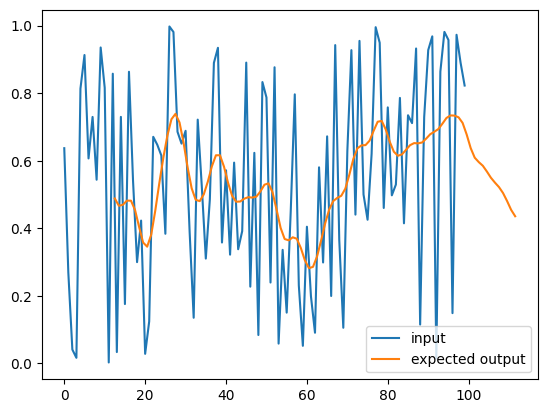

In [4]:
filter_size = 25
problem_size = 50000000


results = []
input = np.random.default_rng(0).random(problem_size + filter_size - 1)

filter = scipy.signal.windows.gaussian(filter_size, 2.0)
filter /= np.sum(filter)

output = np.zeros(problem_size)
output_expect = np.convolve(input, filter, mode="valid")

plt.plot(np.arange(100), input[:100], label="input")
plt.plot(np.arange(100) + filter_size/2, output_expect[:100], label="expected output")
plt.legend()

### Auto-tuning using Kernel Tuner

The next cell shows a simple example of how to perform accuracy tuning using Kernel Tuner.

In [18]:
import kernel_tuner
from kernel_tuner.accuracy import TunablePrecision, AccuracyObserver
from kernel_tuner.observers.nvml import NVMLObserver

# The tunable types. Currently, the code only tunes for double precision.
#
# ================================================================
# ✏️ Add you own data types here. You can use the following options: ✏️
#
# - "double"
# - "float"
# - "half"
# - "bfloat16"
# ================================================================
#
tune_params = dict()
tune_params["OUTPUT_TYPE"] = ["double", "float", "half", "bfloat16"]
tune_params["INPUT_TYPE"] = ["double", "float", "half", "bfloat16"]
tune_params["FILTER_TYPE"] = ["double", "float", "half", "bfloat16"]
tune_params["ACCUM_TYPE"] = ["double", "float", "half", "bfloat16"]

# Other tunable parameters
tune_params["block_size_x"] = [128, 256]
tune_params["loop_unroll_factor_filter"] = [1, 5, 25]
tune_params["VECTOR_SIZE"] = [1, 2, 4]
tune_params["PREFETCH_INPUT"] = [0, 1]


# Do not modify this cell below this line
# =======================================

# Kernel arguments wrapped in `TunablePrecision`s
args = [
    TunablePrecision("OUTPUT_TYPE", output),
    TunablePrecision("INPUT_TYPE", input),
    TunablePrecision("FILTER_TYPE", filter),
]

# The expected output
answer = [output_expect, None, None]

# Add observers to measure the accuracy and energy
observers = [AccuracyObserver("RMSE"), NVMLObserver(["nvml_energy", "nvml_power"])]

# Tune for 2 minutes using random sampling
strategy = "random_sample"
strategy_options = dict(time_limit=10 * 60, fraction=1)

# These compiler options are needed for compilation.
compiler_options=[
    "--std=c++17",
    "-I/content",
    "-I/usr/local/cuda/include",
    f"-DINPUT_SIZE={len(input)}",
    f"-DOUTPUT_SIZE={len(output)}",
    f"-DFILTER_SIZE={len(filter)}",
]

# There are no restrictions for this kernel
restriction = lambda p: not ("bfloat16" in p.values() and "half" in p.values()) and "double" not in p.values()

# Run kernel tuner!
results_batch, env = kernel_tuner.tune_kernel(
    "convolution",
    "convolution.cu",
    problem_size,
    args,
    tune_params,
    compiler_options=compiler_options,
    answer=answer,
    observers=observers,
    lang="NVCUDA",
    strategy=strategy,
    strategy_options=strategy_options,
    iterations=15,
    restrictions=restriction,
    cache="convolution"
)

results += results_batch

Using: Tesla T4
OUTPUT_TYPE=float, INPUT_TYPE=float, FILTER_TYPE=bfloat16, ACCUM_TYPE=bfloat16, block_size_x=256, loop_unroll_factor_filter=5, VECTOR_SIZE=4, PREFETCH_INPUT=1, time=9.220ms
OUTPUT_TYPE=bfloat16, INPUT_TYPE=float, FILTER_TYPE=float, ACCUM_TYPE=bfloat16, block_size_x=128, loop_unroll_factor_filter=5, VECTOR_SIZE=4, PREFETCH_INPUT=1, time=10.141ms
OUTPUT_TYPE=float, INPUT_TYPE=half, FILTER_TYPE=half, ACCUM_TYPE=float, block_size_x=256, loop_unroll_factor_filter=25, VECTOR_SIZE=4, PREFETCH_INPUT=0, time=1.558ms
OUTPUT_TYPE=half, INPUT_TYPE=float, FILTER_TYPE=float, ACCUM_TYPE=float, block_size_x=128, loop_unroll_factor_filter=1, VECTOR_SIZE=4, PREFETCH_INPUT=1, time=5.985ms
OUTPUT_TYPE=float, INPUT_TYPE=float, FILTER_TYPE=half, ACCUM_TYPE=half, block_size_x=128, loop_unroll_factor_filter=5, VECTOR_SIZE=2, PREFETCH_INPUT=0, time=2.756ms
OUTPUT_TYPE=float, INPUT_TYPE=half, FILTER_TYPE=float, ACCUM_TYPE=float, block_size_x=128, loop_unroll_factor_filter=5, VECTOR_SIZE=1, PREFE

### Analyzing the Results

We can convert the results into a Pandas dataframe to visualize them using a table.

In [19]:
# Convert to DataFrame and remove some unnecessary columns
remove_columns = ["times", "timestamp", "compile_time", "strategy_time", "benchmark_time", "verification_time", "framework_time"]
df = pandas.DataFrame(results).drop(columns=remove_columns).sort_values("time")

# Find speedup over lowest error, which should be double precision
baseline_time = 10.605600 #df["time"][df["error"] == df["error"].min()].min()
df["speedup"] = baseline_time / df["time"]

# Add column that indicates used data types
type_columns = ["OUTPUT_TYPE", "INPUT_TYPE", "FILTER_TYPE", "ACCUM_TYPE"]
df["data_types"] = df[type_columns].apply(lambda row: "+".join(sorted(set(row))), axis=1)

# Show table
df

,OUTPUT_TYPE,INPUT_TYPE,FILTER_TYPE,ACCUM_TYPE,block_size_x,loop_unroll_factor_filter,VECTOR_SIZE,PREFETCH_INPUT,error,time,nvml_energy,nvml_power,speedup,data_types
316,half,half,float,half,256,25,4,1,0.000304,1.075253,0.075383,70.107,9.863350,float+half
655,half,half,half,float,256,25,4,1,0.000121,1.076098,0.076390,70.988,9.855607,float+half
575,half,half,float,half,128,25,4,1,0.000304,1.090978,0.076758,70.357,9.721185,float+half
247,half,half,half,half,128,25,4,1,0.000304,1.103930,0.077765,70.444,9.607134,half
481,half,half,half,half,128,25,4,1,0.000304,1.103930,0.077765,70.444,9.607134,half
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,double,double,double,bfloat16,256,25,2,1,0.002282,81.928155,5.727761,69.912,0.129450,bfloat16+double
303,double,double,double,bfloat16,128,1,4,1,0.002282,100.445732,6.957876,69.270,0.105585,bfloat16+double
54,bfloat16,double,double,bfloat16,128,1,2,0,0.002282,119.564248,7.942892,66.432,0.088702,bfloat16+double
239,double,double,double,bfloat16,256,1,1,0,0.002282,159.411614,10.596568,66.473,0.066530,bfloat16+double


We can visualize the results on a performance vs error plot. We group them based on the data types used. For example, `half+double` means the data types used are a combination of `double` and `half`.

<Axes: title={'center': 'Energy versus error'}, xlabel='Energy usage (J)', ylabel='Error (RMSE)'>

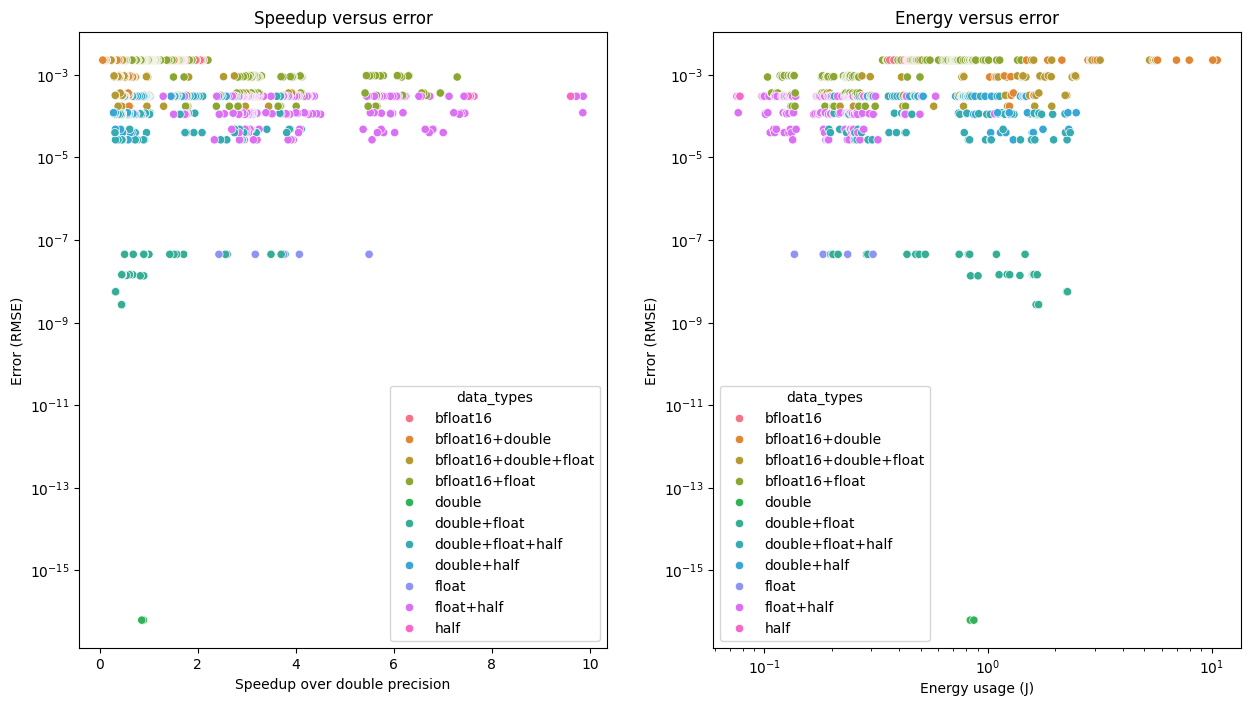

In [20]:
plt.subplots(1, 2, figsize=(15, 8))

# Speedup versus error
plt.subplot(121)
plt.title("Speedup versus error")
plt.yscale("log")
plt.xlabel("Speedup over double precision")
plt.ylabel("Error (RMSE)")
seaborn.scatterplot(df, x="speedup", y="error", hue="data_types", hue_order=sorted(set(df["data_types"])))

# Energy versus error
plt.subplot(122)
plt.title("Energy versus error")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Energy usage (J)")
plt.ylabel("Error (RMSE)")
seaborn.scatterplot(df, x="nvml_energy", y="error", hue="data_types", hue_order=sorted(set(df["data_types"])))

### Pareto front

Next we determine the _pareto front_. The pareto front is the set of all configurations that are _optimal_ in the sense that it is not possible to improve one property (the error or the run time or the energy) without sacrificing some other property.

First, we print the pareto optimal points as a dataframe:

In [21]:
# Function that checks if `row` dominates all other rows
def dominates(row):
    dominators = (row.time >= df["time"]) & (row.error >= df["error"]) & (row.nvml_energy >= df["nvml_energy"]) & \
              ((row.time > df["time"]) | (row.error > df["error"]) | (row.nvml_energy > df["nvml_energy"]))

    return not dominators.any()

# Extract the pareto front
df["pareto"] = df.apply(dominates, axis=1)

df.loc[df["pareto"]].sort_values("time")

,OUTPUT_TYPE,INPUT_TYPE,FILTER_TYPE,ACCUM_TYPE,block_size_x,loop_unroll_factor_filter,VECTOR_SIZE,PREFETCH_INPUT,error,time,nvml_energy,nvml_power,speedup,data_types,pareto
316,half,half,float,half,256,25,4,1,3.040946e-04,1.075253,0.075383,70.107,9.863350,float+half,True
655,half,half,half,float,256,25,4,1,1.212265e-04,1.076098,0.076390,70.988,9.855607,float+half,True
440,half,half,float,float,128,25,4,0,1.182380e-04,1.423904,0.100661,70.694,7.448255,float+half,True
391,half,float,float,float,128,25,4,1,1.112559e-04,1.444753,0.101209,70.053,7.340770,float+half,True
434,float,half,float,float,128,25,2,1,4.002579e-05,1.513321,0.106178,70.162,7.008165,float+half,True
604,float,float,half,float,256,25,2,1,2.677107e-05,1.908858,0.133824,70.107,5.555993,float+half,True
565,float,float,float,float,256,25,2,1,4.507359e-08,1.929619,0.136223,70.596,5.496214,float,True
217,float,float,float,float,256,25,2,1,4.507359e-08,1.929619,0.136223,70.596,5.496214,float,True
110,float,double,double,double,128,25,2,1,1.358202e-08,11.771887,0.835663,70.988,0.900926,double+float,True
89,double,double,double,double,128,25,4,1,6.184908e-17,11.837222,0.833352,70.401,0.895953,double,True


We can also visualize the front on a speedup-error scatter plot:

<Axes: title={'center': 'Speedup versus error'}, xlabel='Speedup over double precision', ylabel='Error (RMSE)'>

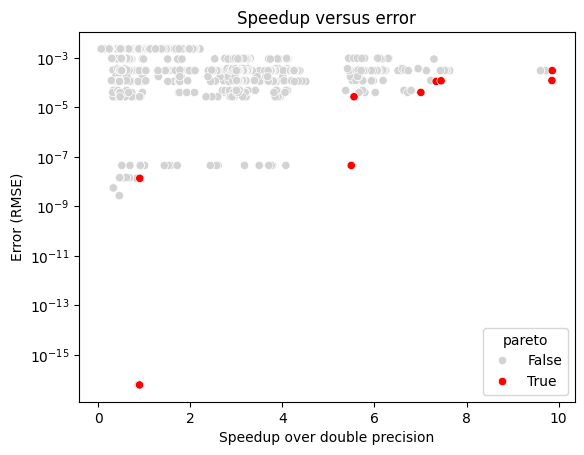

In [22]:
# Speedup versus error
plt.title("Speedup versus error")
plt.yscale("log")
plt.xlabel("Speedup over double precision")
plt.ylabel("Error (RMSE)")

seaborn.scatterplot(df.sort_values("pareto"), x="speedup", y="error", hue="pareto", palette=["lightgray", "red"])

## Go experiment!
Now, go back up to [cell 5](#scrollTo=WsBGYMdn440C), change some of the data types in `tune_params`, and execute the cell again. Afterwards, you can rerun the subsequent cells to see new results for different combinations of types.


**That's it! You've successfully completed the third hands-on!**